In [1]:
import numpy as np
import matplotlib.pyplot as plt
from nnfs.datasets import spiral_data

# Building and training of neural network with backpropagation, gradient descent, learning rate decay and ADAGRAD Optimzer from scratch

## Load the dataset

[[-0.          0.        ]
 [ 0.00063683  0.01008092]
 [ 0.0009551   0.02017943]
 [ 0.02662279  0.01447413]
 [-0.00234092  0.04033617]]
[0 0 0 0 0]


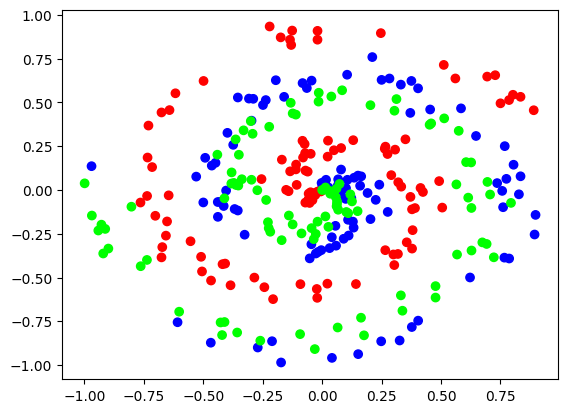

In [2]:
X, y = spiral_data(samples=100, classes=3)

print(X[:5])
print(y[:5])
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="brg")
plt.show()

## Dense Layer

In [3]:
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons):
        self.n_inputs = n_inputs
        self.n_neurons = n_neurons
        self.weights = 0.01 * np.random.rand(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    # forward method
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases

    # backward method (backpropagation)
    def backward(self, dL_dz):
        # Gradient of loss with respect to weights
        self.dL_dw = np.dot(self.inputs.T, dL_dz)

        # Gradient of loss with respect to biases
        self.dL_db = np.sum(dL_dz, axis=0, keepdims=True)

        # Gradient of loss with respect to inputs
        self.dL_dX = np.dot(dL_dz, self.weights.T)

## ReLU Activation

In [4]:
class Activation_ReLU:
    #forward method
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)

    # backward method (backpropagation)
    def backward(self, dL_da):
        self.dL_dz = dL_da.copy()

        # Gradient calculation
        self.dL_dz[self.inputs <= 0] = 0

## Softmax Activation

In [5]:
class Activation_Softmax:
    def forward(self, final_layer_outputs):
        exp_values = np.exp(final_layer_outputs - np.max(final_layer_outputs, axis=1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities

## Loss function

In [6]:
class Loss:
    def calculate(self, y_pred, y_true):
        neg_log_likelihoods = self.forward(y_pred, y_true)
        avg_loss = np.mean(neg_log_likelihoods)
        return avg_loss

class Loss_CategoricalCrossEntropy(Loss):
    def forward(self, y_pred, y_true):
        y_pred_clipped = np.clip(y_pred, 1e-7, 1-1e-7)

        if len(y_true.shape) == 1:
            correct_predictions = y_pred_clipped[range(len(y_pred_clipped)), y_true]
            
        if len(y_true.shape) == 2:
            correct_predictions = np.sum(y_pred_clipped*y_true, axis=1)

        neg_log_likelihoods = -np.log(correct_predictions)
        return neg_log_likelihoods

## Combined Softmax Activation and Loss function

In [7]:
class Activation_Softmax_Loss_CategoricalCrossEntropy:
    def __init__(self):
        self.activation_softmax = Activation_Softmax()
        self.loss_function = Loss_CategoricalCrossEntropy()

    # forward method
    def forward(self, final_layer_output, y_true):
        self.activation_softmax.forward(final_layer_output)
        self.softmax_output = self.activation_softmax.output
        self.loss = self.loss_function.calculate(self.softmax_output, y_true)

        return self.loss

    # backward method (backpropagation)
    def backward(self, y_pred, y_true):
        no_of_batches = len(y_pred)
        
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)

        self.dL_dz = self.softmax_output.copy()

        # Gradient calculation
        self.dL_dz[range(no_of_batches), y_true] -= 1

        # Normalization
        self.dL_dz = self.dL_dz / no_of_batches

# ADAGRAD Optimizer with decaying learning rate

In [1]:
class Optimizer_ADAGRAD:
    def __init__(self, learning_rate=1., decay=0., epsilon=1e-7):
        self.learning_rate = learning_rate # initial learning rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.epsilon = epsilon
        self.epoch = 0

    def pre_update_params(self):
        self.current_learning_rate = self.learning_rate / (1. + self.decay * self.epoch)

    def update_params(self, layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        # update cache with squared current gradients
        layer.weight_cache += layer.dL_dw**2
        layer.bias_cache += layer.dL_db**2

        # Vanilla SGD optimizer + normalization with square root of caches
        layer.weights += -self.current_learning_rate * layer.dL_dw / \
                    (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * layer.dL_db / \
                    (np.sqrt(layer.bias_cache) + self.epsilon)

    def post_update_params(self):
        self.epoch += 1

## Training the neural network

Epoch: 0 Accuracy: 0.260 Loss: 1.099 lr: 1.0
Epoch: 100 Accuracy: 0.400 Loss: 0.989 lr: 0.9099181073703367
Epoch: 200 Accuracy: 0.417 Loss: 0.952 lr: 0.8340283569641367
Epoch: 300 Accuracy: 0.467 Loss: 0.926 lr: 0.7698229407236336
Epoch: 400 Accuracy: 0.530 Loss: 0.895 lr: 0.7147962830593281
Epoch: 500 Accuracy: 0.540 Loss: 0.880 lr: 0.66711140760507
Epoch: 600 Accuracy: 0.553 Loss: 0.869 lr: 0.6253908692933083
Epoch: 700 Accuracy: 0.560 Loss: 0.860 lr: 0.5885815185403178
Epoch: 800 Accuracy: 0.560 Loss: 0.834 lr: 0.5558643690939411
Epoch: 900 Accuracy: 0.570 Loss: 0.807 lr: 0.526592943654555
Epoch: 1000 Accuracy: 0.570 Loss: 0.793 lr: 0.5002501250625312
Epoch: 1100 Accuracy: 0.577 Loss: 0.780 lr: 0.4764173415912339
Epoch: 1200 Accuracy: 0.583 Loss: 0.772 lr: 0.45475216007276037
Epoch: 1300 Accuracy: 0.583 Loss: 0.765 lr: 0.43497172683775553
Epoch: 1400 Accuracy: 0.593 Loss: 0.761 lr: 0.4168403501458941
Epoch: 1500 Accuracy: 0.593 Loss: 0.757 lr: 0.4001600640256102
Epoch: 1600 Accuracy

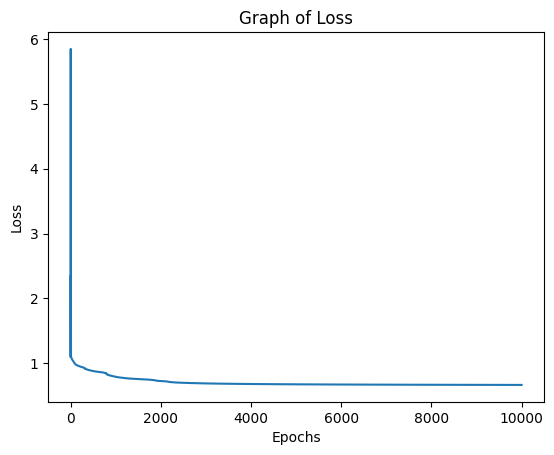

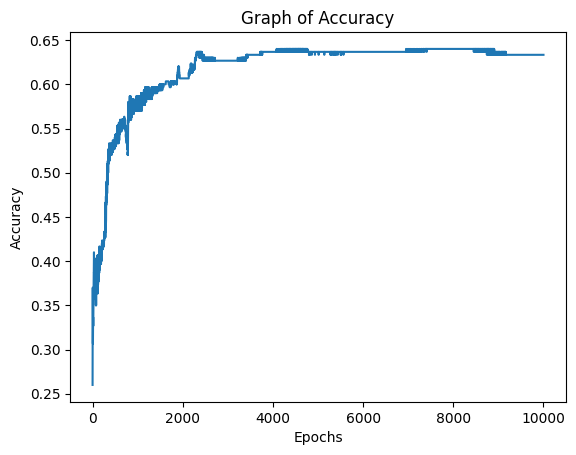

In [15]:
# Defining the architecture
dense_layer1 = Layer_Dense(2, 64)
activation_relu = Activation_ReLU()
dense_layer2 = Layer_Dense(64, 3)
softmax_loss = Activation_Softmax_Loss_CategoricalCrossEntropy()

# SGS Optimizer
optimizer_adagrad = Optimizer_ADAGRAD(decay=1e-3)

loss_history = []
acc_history = []

for epoch in range(10001):
    # entire forward pass
    dense_layer1.forward(X)
    activation_relu.forward(dense_layer1.output)
    dense_layer2.forward(activation_relu.output)
    softmax_loss.forward(final_layer_output=dense_layer2.output, y_true=y)

    loss = softmax_loss.loss
    loss_history.append(loss)

    predictions = np.argmax(softmax_loss.softmax_output, axis=1)
    accuracy = np.mean(predictions == y)
    acc_history.append(accuracy)

    if epoch % 100 == 0:
        print(f'Epoch: {epoch} Accuracy: {accuracy:.3f} Loss: {loss:.3f} lr: {optimizer_adagrad.current_learning_rate}')

    # entire backward pass (backpropagation)
    softmax_loss.backward(softmax_loss.softmax_output, y)
    dense_layer2.backward(dL_dz=softmax_loss.dL_dz)
    activation_relu.backward(dL_da=dense_layer2.dL_dX)
    dense_layer1.backward(dL_dz=activation_relu.dL_dz)

    # Applying optimizer (Gradient descent with decaying learning rate and momentum)
    optimizer_adagrad.pre_update_params()
    optimizer_adagrad.update_params(dense_layer1)
    optimizer_adagrad.update_params(dense_layer2)
    optimizer_adagrad.post_update_params()

plt.plot(loss_history)
plt.title("Graph of Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()

plt.plot(acc_history)
plt.title("Graph of Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()